In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from numba import jit, prange

In [33]:
def distance_torus(point, field_x, field_y, size):
    return np.sqrt(np.minimum(np.abs(field_x-point[0]), (-1*np.abs(field_x-point[0]))%size)**2 + np.minimum(np.abs(field.T[1]-point[1]), (-1*np.abs(field.T[1]-point[1]))%size)**2)

def distance(point, field, size):
    return np.sqrt((point[0] - field.T[0])**2 + (point[1]-field.T[1])**2)

def is_greater(point, field, spacing, size):
    return not np.any(distance_torus(point, field, size) < spacing)

def initialize_field(spacing, size, attempts):
    field = size*np.random.random([1,2])
    tries = 0
    while tries < attempts:
        test = size*np.random.random([1,2])
        if is_greater(test[0], field, spacing, size):
            field = np.append(field, test, axis = 0)
            tries = 0
        else:
            tries += 1
    return field

#-----------------------------------------------------------------------

def next_flower(field, current, reach, size):
    indices = np.where(distance_torus(field[current], field, size) < reach)[0]
    indices = indices[indices != current]
    if len(indices) > 0:
        weights = 1/distance_torus(field[current], field[indices], size)
        weights *= 1/np.sum(weights)
        choice = np.random.choice(indices, p = weights)
        return choice
    else:
        return -1
    
def flight_of_the_bumblebee(field, reach, size):
    ind = np.random.randint(len(field))
    flight = np.array([field[ind]])
    
    while ind != -1:
        next_ind = next_flower(field, ind, reach, size)
        if len(field) > 1:
            field = np.delete(field, ind, axis = 0)
        if next_ind > ind:
            ind = next_ind - 1
        else:
            ind = next_ind
        flight = np.append(flight, [field[ind]], axis = 0)
            
    return flight[:-1]

#-------------------------------------------------------------------------

def pollination(flight, size, spacing, attempts):
    for i in range(len(flight)):
        tries = 0
        while tries < attempts:
            test = (flight[i] + 1.5*spacing*(2*np.random.random([1,2])-1))%size
            if is_greater(test[0], flight, spacing, size):
                flight = np.append(flight, test, axis = 0)
                tries = attempts
            else:
                tries += 1
    return flight

def Knapskogs_game_of_life(size, attempts, spacing, reach, iterations):
    field = initialize_field(spacing, size, attempts)
    for i in range(iterations):
        flight = flight_of_the_bumblebee(field, reach, size)
        new_field = pollination(flight, size, spacing, attempts)
        plt.plot(field.T[0], field.T[1], "*", markersize = 5)
        plt.plot(new_field.T[0], new_field.T[1], "*", markersize = 5)
        plt.xlim(0, size)
        plt.ylim(0, size)
        plt.title(f"iteration = {i}")
        plt.show()
        clear_output(wait=True)
        field = new_field

In [83]:
@jit(nopython=True)
def distance_torus(point_x, point_y, field_x, field_y, size):
    return np.sqrt(np.minimum(np.abs(field_x-point_x), (-1*np.abs(field_x-point_x))%size)**2 + np.minimum(np.abs(field_y-point_y), (-1*np.abs(field_y-point_y))%size)**2)

@jit(nopython=True)
def is_greater(point_x, point_y, field_x, field_y, spacing, size):
    return not np.any(distance_torus(point_x, point_y, field_x, field_y, size) < spacing)

@jit(nopython=True)
def initialize_field(spacing, size, attempts, field_x):
    field_y = field_x.copy()
    field_x *= size*np.random.random()
    field_y *= size*np.random.random()
    tries = 0
    while tries < attempts:
        test_x = size*np.random.random()
        test_y = size*np.random.random()
        if is_greater(test_x, test_y, field_x, field_y, spacing, size):
            field_x = np.append(field_x, test_x)
            field_y = np.append(field_y, test_y)
            tries = 0
        else:
            tries += 1
    return field_x, field_y

#-----------------------------------------------------------------------

@jit(nopython=True)
def next_flower(field_x, field_y, current, reach, size):
    indices = np.where(distance_torus(field_x[current], field_y[current], field_x, field_y, size) < reach)[0]
    indices = indices[indices != current]
    if len(indices) > 0:
#         weights = 1/distance_torus(field_x[current], field_y[current], field_x[indices], field_y[indices], size)
#         weights *= 1/np.sum(weights)
        choice = np.random.choice(indices) #, p = weights)
        return choice
    else:
        return -1
    
@jit(nopython=True)
def flight_of_the_bumblebee(field_x, field_y, reach, size):
    ind = np.random.randint(len(field_x))
    flight_x = np.array([field_x[ind]])
    flight_y = np.array([field_y[ind]])
    
    while ind != -1:
        next_ind = next_flower(field_x, field_y, ind, reach, size)
        if len(field_x) > 1:
            field_x = np.delete(field_x, ind)
            field_y = np.delete(field_y, ind)
        if next_ind > ind:
            ind = next_ind - 1
        else:
            ind = next_ind
        flight_x = np.append(flight_x, [field_x[ind]])
        flight_y = np.append(flight_y, [field_y[ind]])
            
    return flight_x[:-1], flight_y[:-1]

#-------------------------------------------------------------------------

@jit(nopython=True)
def pollination(flight_x, flight_y, size, spacing, attempts):
    for i in range(len(flight_x)):
        tries = 0
        while tries < attempts:
            test_x = (flight_x[i] + (-1)**np.random.randint(2)*spacing*(0.5*np.random.random()+1))%size
            test_y = (flight_y[i] + (-1)**np.random.randint(2)*spacing*(0.5*np.random.random()+1))%size
            if is_greater(test_x, test_y, flight_x, flight_y, spacing, size):
                flight_x = np.append(flight_x, test_x)
                flight_y = np.append(flight_y, test_y)
                tries = attempts
            else:
                tries += 1
    return flight_x, flight_y

def Knapskogs_game_of_life(size, attempts, spacing, reach, iterations):
    plt.rcParams["figure.figsize"] = (20,20)
    field_x, field_y = initialize_field(spacing, size, attempts, np.ones(1))
    for i in range(iterations):
        flight_x, flight_y = flight_of_the_bumblebee(field_x, field_y, reach, size)
        new_field_x, new_field_y = pollination(flight_x, flight_y, size, spacing, attempts)
        plt.plot(field_x, field_y, "*", markersize = 10)
        plt.plot(new_field_x, new_field_y, "*", markersize = 10)
        plt.xlim(0, size)
        plt.ylim(0, size)
        plt.title(f"iteration = {i}")
        plt.show()
        clear_output(wait=True)
        field_x = new_field_x
        field_y = new_field_y
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
        
#-------------------------------------------------------------------------

@jit(nopython=True)
def Monte_jobo(size, attempts, spacing, reach, iterations, arr):
    field_x, field_y = initialize_field(spacing, size, 500, arr)
    flowers = 0
    for i in range(10):
        flight_x, flight_y = flight_of_the_bumblebee(field_x, field_y, reach, size)
        new_field_x, new_field_y = pollination(flight_x, flight_y, size, spacing, attempts)
        field_x = new_field_x
        field_y = new_field_y
        
    for i in range(iterations):
        flight_x, flight_y = flight_of_the_bumblebee(field_x, field_y, reach, size)
        new_field_x, new_field_y = pollination(flight_x, flight_y, size, spacing, attempts)
        field_x = new_field_x
        field_y = new_field_y
        flowers += len(field_x)
    
    return flowers/iterations

@jit(nopython=True, parallel = True)
def Monte_Parallelo(size, attempts, spacing, reach, iterations, arr):
    flowers = reach.copy()
    for i in prange(len(reach)):
        flowers[i] = Monte_jobo(size, attempts, spacing, reach[i], iterations, arr)
    return flowers


In [67]:
np.random.randint(2)

1

<IPython.core.display.Javascript object>


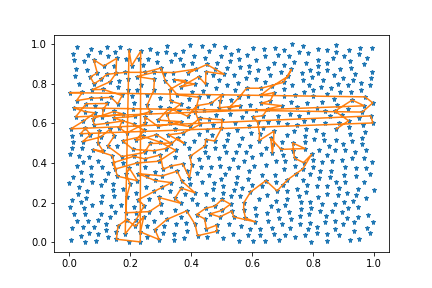

In [19]:
%matplotlib notebook

field_x, field_y = initialize_field(0.03, 1, 5000, np.ones(1))
flight_x, flight_y = flight_of_the_bumblebee(field_x, field_y, 0.08, 1)
# flight2 = pollination(flight, 1, 0.03, 100)

plt.plot(field_x, field_y, "*", markersize = 5)
plt.plot(flight_x, flight_y)
# plt.plot(flight2.T[0], flight2.T[1], "*", markersize = 5)

# plt.plot(flight[-1,0], flight[-1,1], "o")

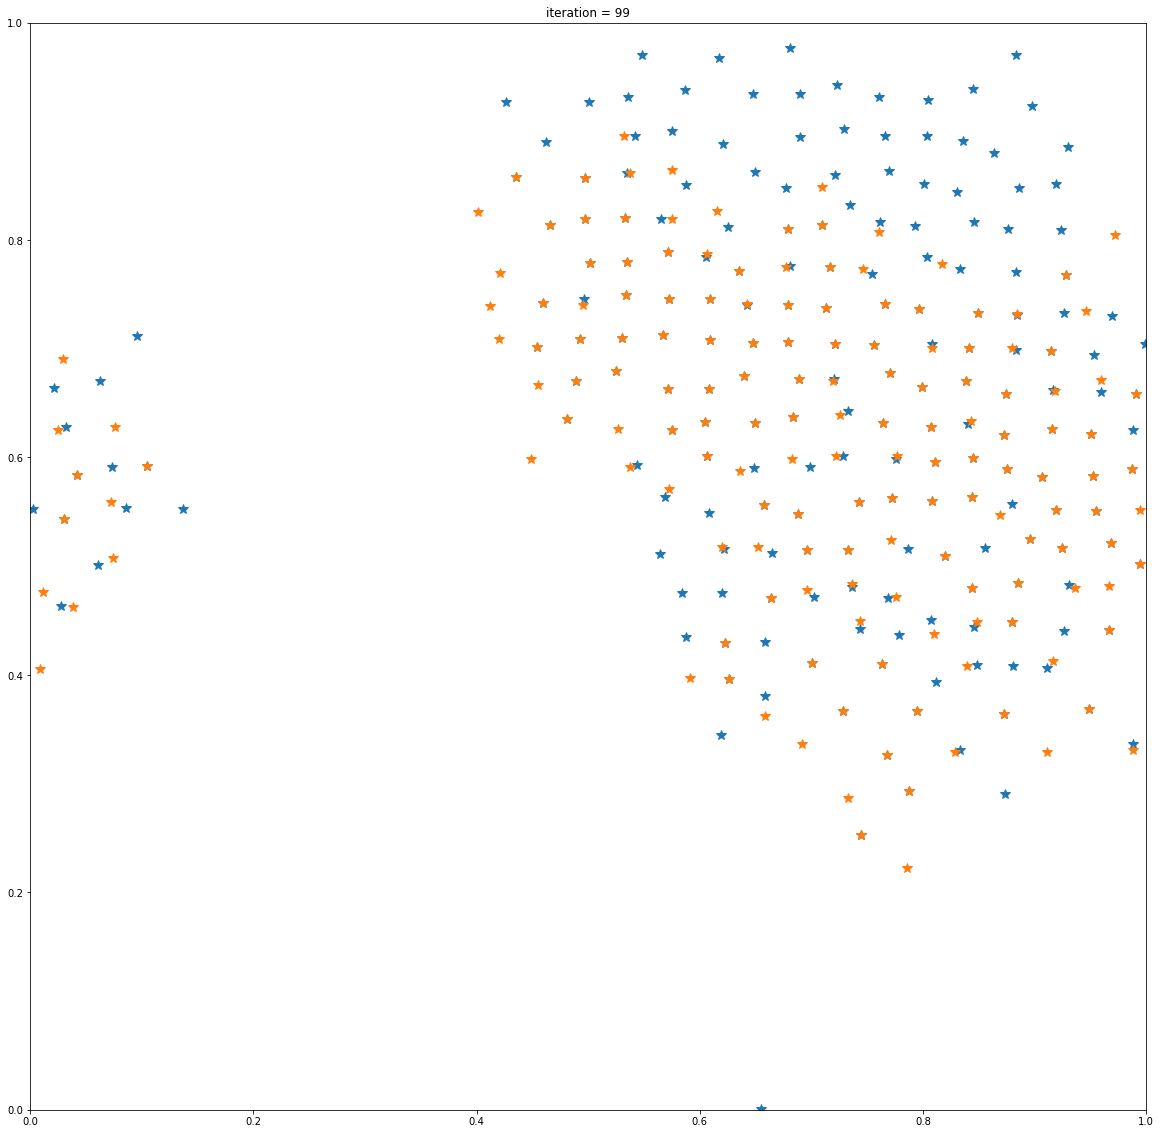

In [90]:
%matplotlib inline
Knapskogs_game_of_life(1, 50, 0.03, 0.11, 100)

In [36]:
utsikt3 = np.linspace(0.112, 0.123, 25)
flower_power3 = Monte_Parallelo(1, 50, 0.03, utsikt3, 1000, np.ones(1))

<IPython.core.display.Javascript object>


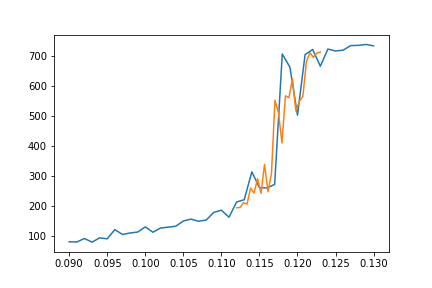

In [40]:
%matplotlib notebook
plt.plot(utsikt, flower_power)
# plt.plot(utsikt2, flower_power2)
plt.plot(utsikt3, flower_power3)

In [52]:
%matplotlib notebook

field_x, field_y = initialize_field(0.03, 1, 500)
flight = flight_of_the_bumblebee(field, 0.08, 1)
# flight2 = pollination(flight, 1, 0.03, 100)

plt.plot(field.T[0], field.T[1], "*", markersize = 5)
plt.plot(flight.T[0], flight.T[1])
# plt.plot(flight2.T[0], flight2.T[1], "*", markersize = 5)

plt.plot(flight[-1,0], flight[-1,1], "o")

TypeError: only integer scalar arrays can be converted to a scalar index